# Image Segmentation Algorithms

Populating the interactive namespace from numpy and matplotlib
Loading the images
Resizing images
Resizing images
Getting the image features
Run intensity segmentation algorithms
K Means with intensity features
	Iteration 0
	Iteration 1
	Iteration 2
Displaying outs


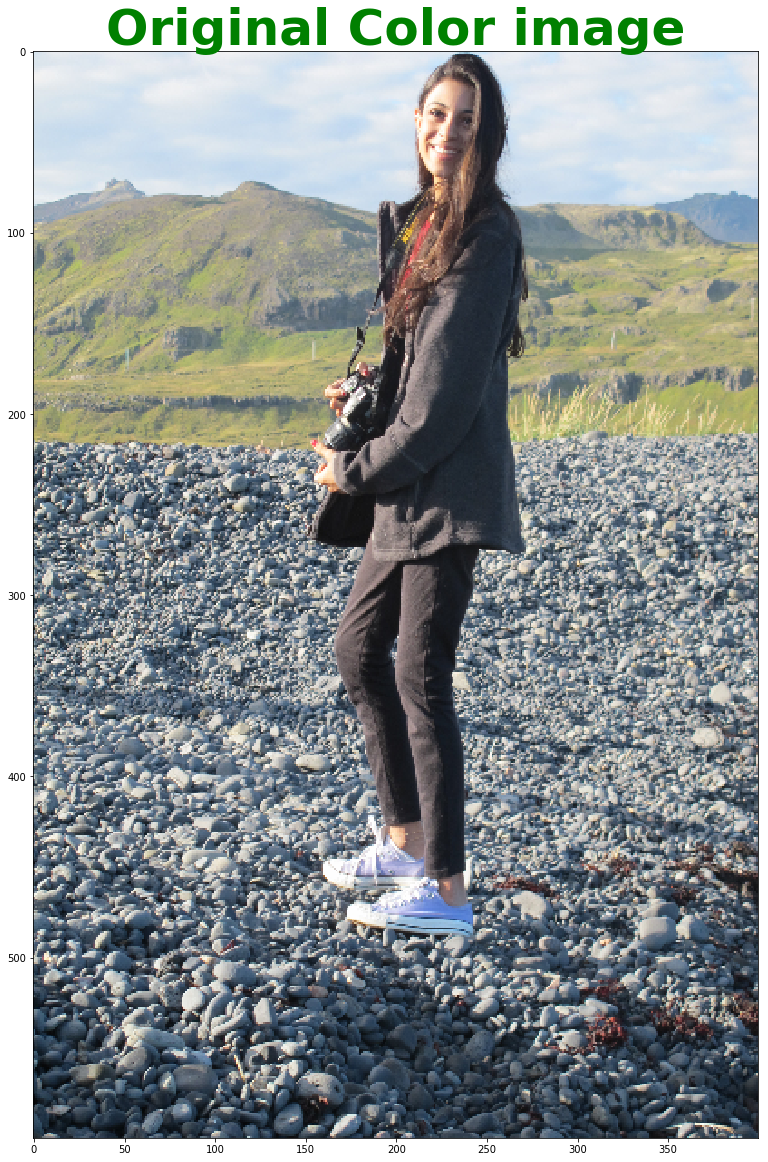

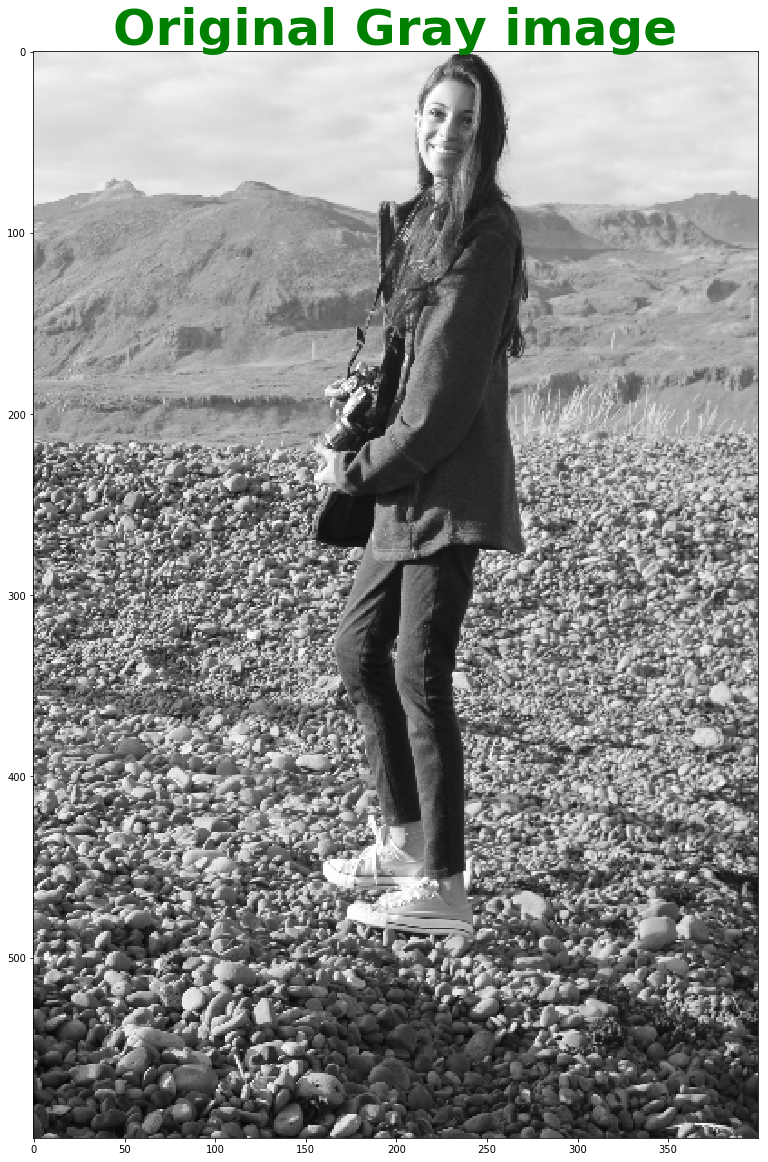

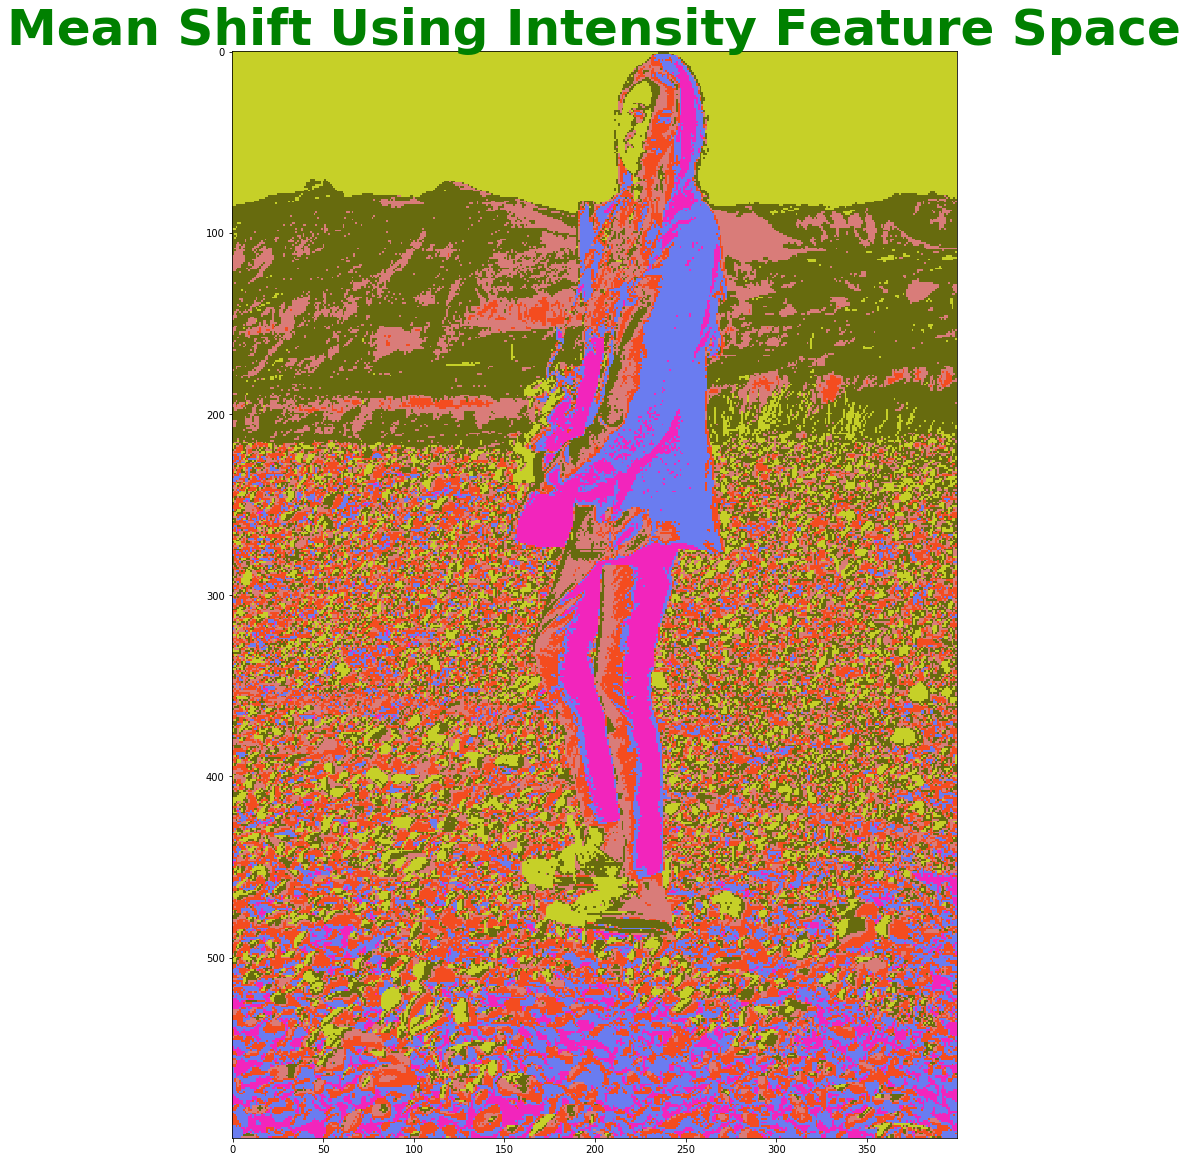

In [42]:
'''
This file has the code for QUESTION 2 of the assignment
'''
import cv2
from matplotlib import pyplot as plt
import numpy as np
import random as r
import itertools
import math
from scipy.spatial import distance


class MS_Window:
    def __init__(self, lower, upper, bin):
        self.lower = lower
        self.upper = upper
        self.sum = 0
        self.mean = 0
        self.oldMean = 0
        self.elements = 0
        self.locked = False
        self.color = [r.randint(0, 255), r.randint(0, 255), r.randint(0, 255)]
        self.bin = bin


class MS_WINDOW_COLOR:
    def __init__(self, color, bin):
        self.sum = [0, 0, 0]
        self.oldColor = Color([0, 0, 0])
        self.elements = 0
        self.locked = False
        self.color = color
        self.bin = bin


class Color:
    def __init__(self, color):
        self.R = color[0]
        self.G = color[1]
        self.B = color[2]

    def getColor(self):
        return [self.B, self.G, self.R]


class ColorFeature:
    def __init__(self, color, x, y, bin):
        self.clr = color
        self.x = x
        self.y = y
        self.bin = bin


class IntensityFeature:
    def __init__(self, x, y, intensity, bin):
        self.x = x
        self.y = y
        self.its = intensity
        self.bin = bin


class kMeansCluster:
    def __init__(self, id, mean):
        self.mean = mean
        self.id = id
        self.sum = 0
        self.elements = 0
        self.oldMean = 0
        self.color = [r.randint(0, 255), r.randint(0, 255), r.randint(0, 255)]

    def computeMean(self):
        self.oldMean = self.mean
        self.mean = int(self.sum / self.elements)
        self.elements = 0
        self.sum = 0
        return self


class Segment:
    DEBUG = False
    outputImages = []
    FONT_SIZE = 50
    MS_WINDOW_SIZE = 50
    GRAY_SHAPE = None
    CLR_SHAPE = None
    MS_COLOR_WINDOWS = None
    kM_Clusters = None

    def resizeImage(self, image, dbug=DEBUG):
        print ("Resizing images")
        if dbug:
            image = cv2.resize(image, (25, 50))
        else:
            image = cv2.resize(image, (400, 600))
        return image

    def displayImage(self, img):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)

    def displayImages(self, images):
        print("Displaying outs")
        for im in images:
            ima = im[0]
            if len(ima.shape) > 2:
                ima = cv2.cvtColor(ima, cv2.COLOR_BGR2RGB)
            else:
                ima = cv2.cvtColor(ima, cv2.COLOR_GRAY2RGB)
            plt.figure(figsize=(80, 20))
            plt.title(im[1], fontsize=self.FONT_SIZE, fontweight='bold', color="green")
            plt.imshow(ima)

    def getImages(self, path):

        im_clr = self.resizeImage(cv2.imread(path))
        self.CLR_SHAPE = im_clr.shape
        self.outputImages.append((im_clr, "Original Color image"))
        im_gray = self.resizeImage(cv2.imread(path, 0))
        self.GRAY_SHAPE = im_gray.shape
        self.outputImages.append((im_gray, "Original Gray image"))
        return im_gray, im_clr

    def getClosestKMeansCluster(self, feature):
        return np.argmin([abs(feature.its - i.mean) for i in self.kM_Clusters])

    def kMeans_Intensity(self, features, k=6, maxIter=3):

        # First create clusters of size k, with varying means
        clusterAv = int(255 / k)
        clusters = [kMeansCluster(i, i * clusterAv) for i in range(k)]
        self.kM_Clusters = clusters

        # Then begin the algorithm
        iterations = 0
        getClosest = np.vectorize(self.getClosestKMeansCluster)
        while (iterations < maxIter):
            print ("\tIteration " + str(iterations))
            # For each average, get it's closest cluster and assign it
            closest = getClosest(features)

            # Update each cluster as well
            for idx, bin in enumerate(closest):
                clusters[bin].elements += 1
                clusters[bin].sum += features[idx].its
                features[idx].bin = bin

            # Then for recompute the new means for each cluster
            for idx, i in enumerate(clusters):
                clusters[idx] = i.computeMean()

            iterations += 1

        # Done iterating, time to reconstruct the image
        newIm = np.zeros(self.CLR_SHAPE, dtype=np.uint8)  # Color the output??
        for i in features:
            x, y = i.x, i.y
            newIm[x][y] = clusters[i.bin].color
        return newIm

    def gausMix(self, image, features, k):
        pass

    def meanShift_Intensity(self, features, winSize=50, maxIter=3, windSimilarity=3):
        '''
        This function will return a segmented image based on intensity features
        :param features: A set of ((x,y),Intensity) features that describe each pixel of image
        :return:
        '''
        # First create the proper number of windows, index in dictionary
        numWindows = int(255 / winSize)
        winHalf = int(winSize / 2)
        windows = dict.fromkeys(range(numWindows), None)

        # Then instantiate each window
        i = 0
        for i in range(numWindows):
            windows[i] = MS_Window(i * winSize, i * winSize + winSize, i)
            i += winSize

        iterations = 0
        lockedWindows = 0
        while (iterations < maxIter):
            print ("\tIteration " + str(iterations))

            # First assign every feature a corresponding window
            for idx, i in enumerate(features):
                # For each feature, get the intensity, and map that to a window
                f = i
                for win in range(numWindows):
                    if not windows[win].locked:
                        if f.its >= windows[win].lower and f.its < windows[win].upper:
                            # then assign the feature to the window
                            windows[win].sum += f.its
                            windows[win].elements += 1

                            # also assign each feature to the proper window number
                            features[idx] = IntensityFeature(f.x, f.y, f.its, win)
                            break

            # Then recompute the means of windows and 'shift' the window
            for i in range(numWindows):
                if (windows[i].locked):
                    continue
                newMean = int(windows[i].sum / windows[i].elements)
                if abs(windows[i].mean - newMean) < windSimilarity:
                    # then we have a convergence
                    windows[i].locked = True
                    lockedWindows += 1
                else:
                    windows[i].mean = newMean
                windows[i].lower = windows[i].mean - winHalf
                windows[i].upper = windows[i].mean + winHalf
                if windows[i].lower < 0: windows[i].lower = 0
                if windows[i].upper > 255: windows[i].lower = 255
                windows[i].sum = 0
                windows[i].elements = 0

            # Convergence when all windows are no longer moving a lot
            if (lockedWindows == numWindows):
                break
            else:
                # Otherwise let's keep on going
                iterations += 1

        # todo concatenate the windows

        '''
            Now that we have our windows, and MS is over,
            we just need to recombine everything based on euclidean distance
        '''
        # Done iterating, time to reconstruct the image
        newIm = np.zeros(self.CLR_SHAPE, dtype=np.uint8)  # Color the output??
        for i in features:
            x, y = i.x, i.y
            newIm[x][y] = windows[i.bin].color
        return newIm

    def euclideanDistance(self, a, b):
        '''
        Does what it says
        :param a: first color
        :param b: second color
        :return: euc. distance between 2 colors
        '''
        return distance.euclidean(a.getColor(), b.getColor())

    def meanShift_ClosestWindow(self, feature, e):
        """
        This is used in the vectorized function for the features
        Given a color feature, it will return the window who's mean has the closest euclidean distance
        to the given feature
        :return: the index of the window the feature belongs to
        """
        dists = e(a=self.colors, b=feature.clr)
        idx = np.argmin(dists)
        return self.MS_COLOR_WINDOWS[self.indexes[idx]].bin  # Return the bin that the feature is closest to.

    def meanShift_Color(self, features, winSize=100, maxIter=3, windSimilarity=3):
        '''
        This is very much like the mean shift with intensity except you are shifting towards a color
        and not an intensity. Sadly color is a 3d space, so you are moving somewhere in space... somewhere
        :param features:
        :param winSize:
        :param maxIter:
        :param windSimilarity:
        :return:
        '''
        # First instantiate each window, which is a 3D space, needs a (r,g,b) corner coord to define its loc
        print ("Creating Windows")
        combos = int(255 / winSize)  # The size of 1 side in the feature space
        combinations = []
        winHalf = int(winSize / 2)
        for i in range(combos):
            combinations.append(i * winSize)
            i += winSize
        permutations = list(itertools.product(combinations, repeat=3))

        # Create the proper number of 3d windows
        numWindows = len(permutations)
        windows = dict((i, None) for i in (range(numWindows)))
        for idx, i in enumerate(permutations):
            av = list(map(lambda x: x + winHalf, i))
            window = MS_WINDOW_COLOR(Color(av), idx)
            windows[idx] = window

        print ("Begin the mean shift algorithm")
        # Then start the mean shift algorithm
        iterations = 0
        lockedWindows = 0
        self.MS_COLOR_WINDOWS = windows

        # Vectorize the closestWindow function and eucDist functions
        euc = np.vectorize(self.euclideanDistance, excluded='b', cache=True)
        closestC = np.vectorize(self.meanShift_ClosestWindow, excluded='euc', cache=True)

        while (iterations < maxIter):
            print ("\t\tIteration " + str(iterations))
            # Trim the old windows to only have the new ones
            # windows = [self.MS_COLOR_WINDOWS[i] for i in range(len(self.MS_COLOR_WINDOWS)) if self.MS_COLOR_WINDOWS[i] != None]
            windows = dict((k, v) for k, v in windows.iteritems() if v is not None)
            self.MS_COLOR_WINDOWS = windows
            self.colors = np.array([i.color for j, i in self.MS_COLOR_WINDOWS.iteritems()], dtype=object)
            self.indexes = np.array([i.bin for j, i in self.MS_COLOR_WINDOWS.iteritems()], dtype=object)

            # First assign every feature a corresponding window it's closest to using vec.functions
            closestWindows = closestC(features, e=euc)

            # Then start to update each window with the colors that belong to the window
            for bin, index, feat in zip(closestWindows, range(len(features)), features):
                window = windows[bin]
                try:
                    window.sum = np.add(window.sum, feat.clr.getColor())
                except Exception:
                    print "e"
                window.elements += 1
                # update the features list
                features[index] = ColorFeature(feat.clr, feat.x, feat.y, window.bin)

            # Then recompute the means of windows and 'shift' the window
            for idx, wind in windows.iteritems():
                if wind.elements == 0 or wind == None:
                    windows[idx] = None  # Kind of like deleting the window
                    self.MS_COLOR_WINDOWS = windows
                    continue
                elif (wind.locked):
                    continue
                else:
                    w = MS_WINDOW_COLOR(wind.color, wind.bin)
                    # Compute the mean
                    mean = [int(i / wind.elements) for i in windows[idx].sum]

                    # Get the euclidean distance from the old mean to the new mean
                    dist = distance.euclidean(wind.color.getColor(), mean)

                    # If the window hasn't moved a whole lot, then lock it in
                    if dist < windSimilarity:
                        # then we have a convergence, lock the window
                        wind.locked = True
                        lockedWindows += 1
                    else:
                        w.color = Color(mean)
                        w.oldColor = wind.color
                        w.bin = wind.bin
                        windows[idx] = w

            # Convergence when all windows are no longer moving a lot
            if (lockedWindows == numWindows):
                break
            else:
                # Otherwise let's keep on going
                iterations += 1

        '''
            Now that we have our windows, and MS is over,
            we just need to recombine everything based on euclidean distance
        '''

        newIm = np.zeros(self.CLR_SHAPE, dtype=np.uint8)  # Color the output??
        for i in features:
            x, y = i.x, i.y
            newIm[x][y] = windows[i.bin].color.getColor()
        return newIm

    def getFeatures(self, im, imGray):
        '''
        This function will loop through each pixel in the image and then get the key features
        :return:
        '''
        # bins = np.histogram(im,range(256))
        intensityFeatures = []
        colorFeatures = []

        for i in range(len(im)):
            for j in range(len(im[i])):
                intensityFeatures.append(IntensityFeature(i, j, imGray[i][j], 0))
                colorFeatures.append(ColorFeature(Color(im[i][j]), i, j, 0))
        if self.DEBUG:
            plt.hist(im.ravel(), 256, [0, 256]);
            plt.autoscale()
            plt.savefig("./images/histogram.png")
            hist = cv2.imread("./images/histogram.png")
            self.outputImages.append((hist, "Intensity Histogram"))

        return intensityFeatures, colorFeatures

    def intensitySegmentation(self, features):
        '''
        Using the intensity feature space, run all of the segmentation algorithms
        :param features: A list of features, 1 for each x,y coordinate
        :return: the ms, kmeans and gaus images all segmented
        '''
        ms_int, km_int, gaus_int = None,None,None
        
        
        # Do Mean Shift
        # print "Mean shift with intensity features"
        # ms_int = self.meanShift_Intensity(features, self.MS_WINDOW_SIZE)

        # Do kmeans
        print "K Means with intensity features"
        km_int = self.kMeans_Intensity(features)


        return ms_int,km_int,gaus_int


    def colorSegmentation(self, features):
        print "\tMean shift with color features"
        ms_Color = self.meanShift_Color(features)

        return ms_Color

    def main(self):
        '''
        This is the main function for the segmentation class
        :return:i
        '''
        # First get the images
        print ("Loading the images")
        path = "./images/sarina.jpg"
        im_gray, im_color = self.getImages(path)

        # Then get the feature spaces for Intensity and RGB
        print ("Getting the image features")
        intensity_features, color_features = self.getFeatures(im_color, im_gray)

        # Then do the segmentations for the intensity features
        print "Run intensity segmentation algorithms"
        ms_int, km_int, gaus_int = self.intensitySegmentation(intensity_features)
        self.outputImages.append((km_int, "Mean Shift Using Intensity Feature Space"))

        # Then do segmentations for the color features
        # print "Run color feature space algorithms"
        # ms_color = self.colorSegmentation(color_features)
        # self.outputImages.append((ms_color, "Mean Shift Using Color Feature Space"))

        # Display output images
        self.displayImages(self.outputImages)


%pylab inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (60, 30)
c = Segment()
c.main()


# Panorama Stitching

Populating the interactive namespace from numpy and matplotlib
Finding the right image keypoints
Finding the left image keypoints
Finding matches between images
done
Displaying outs


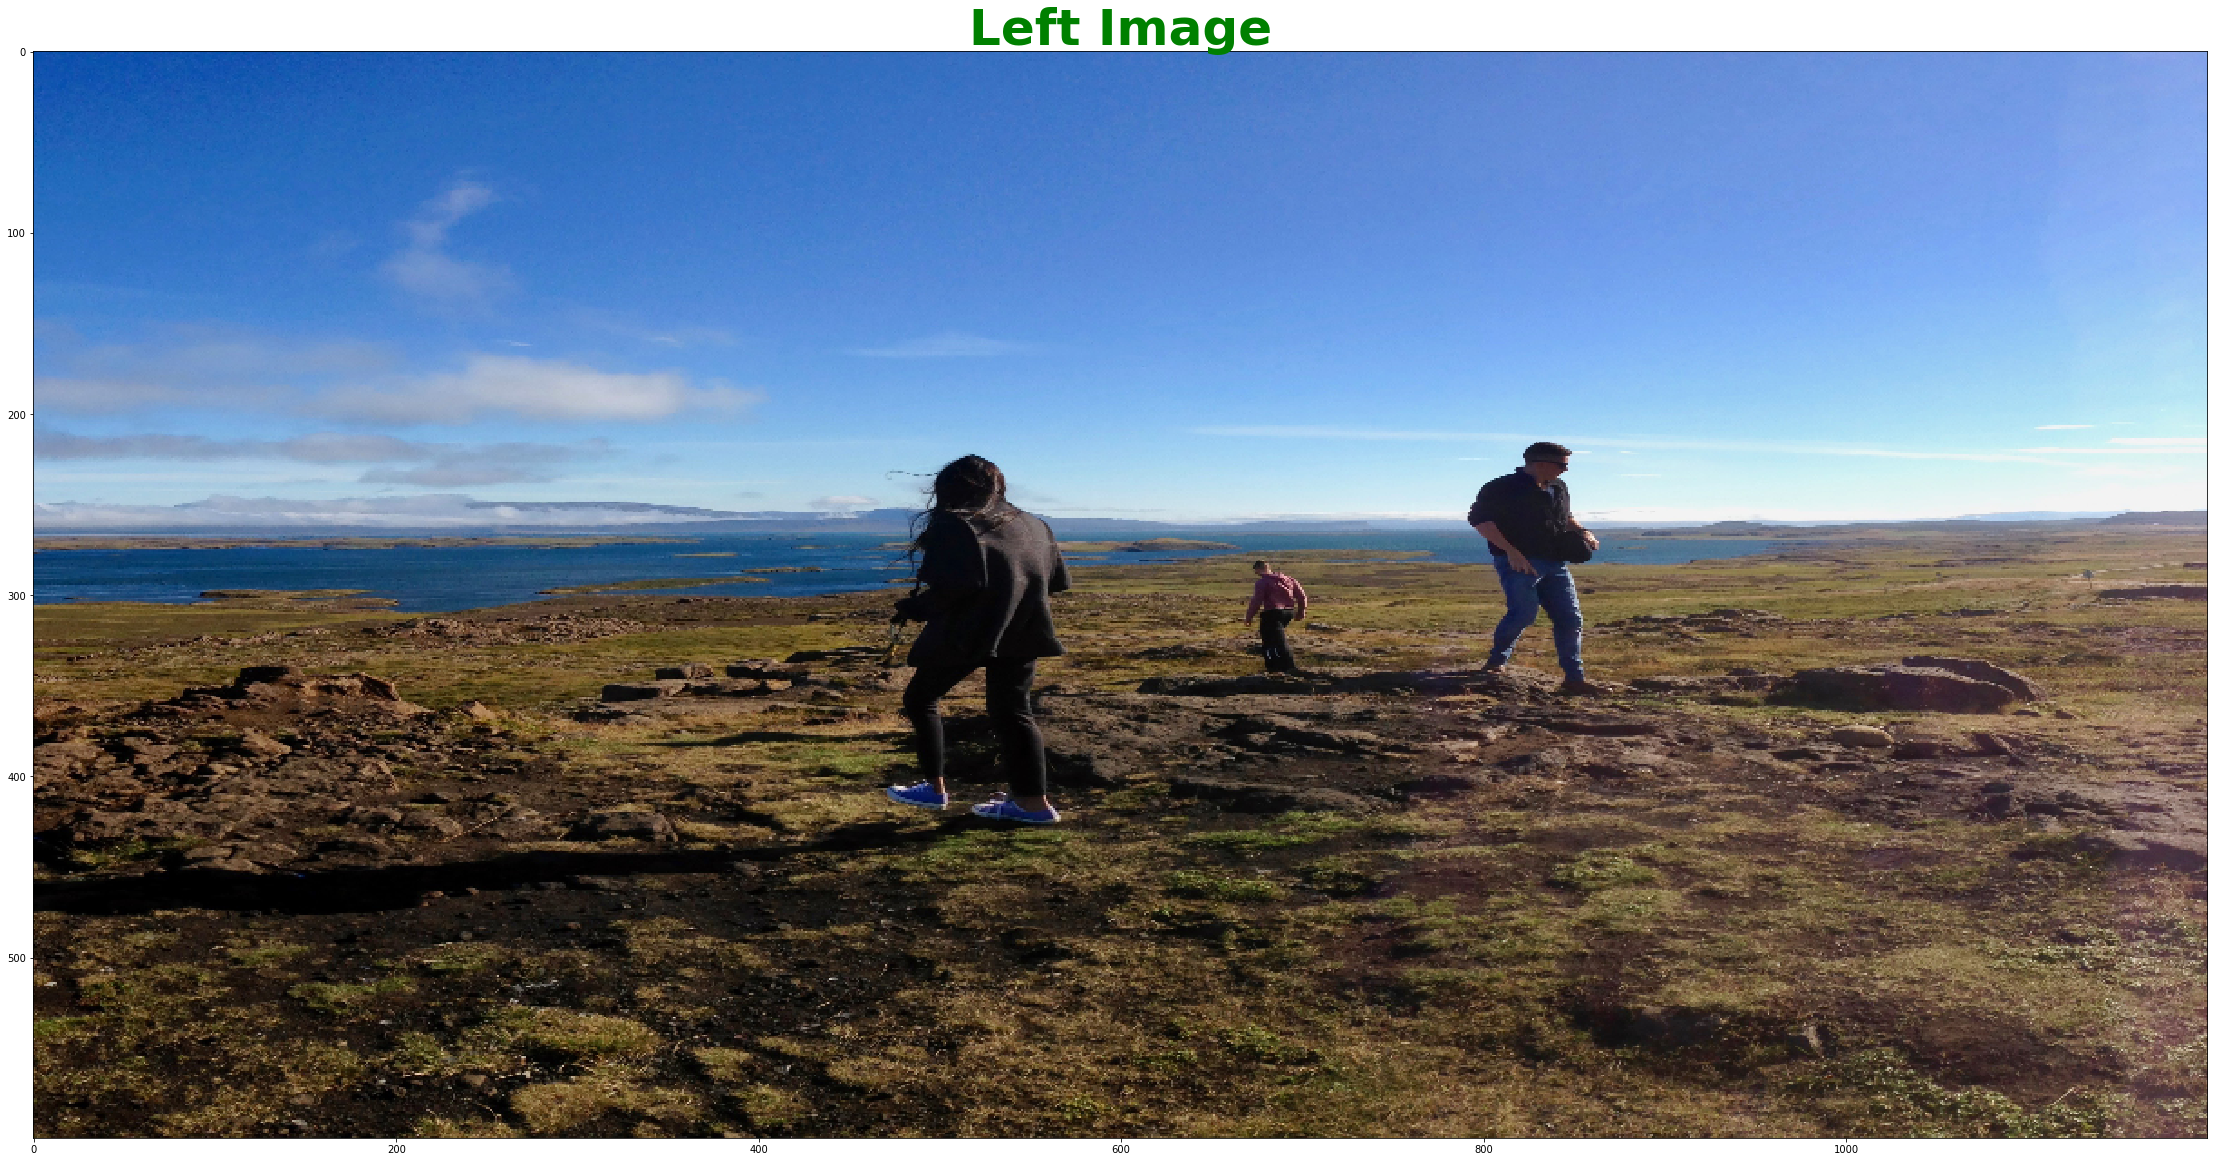

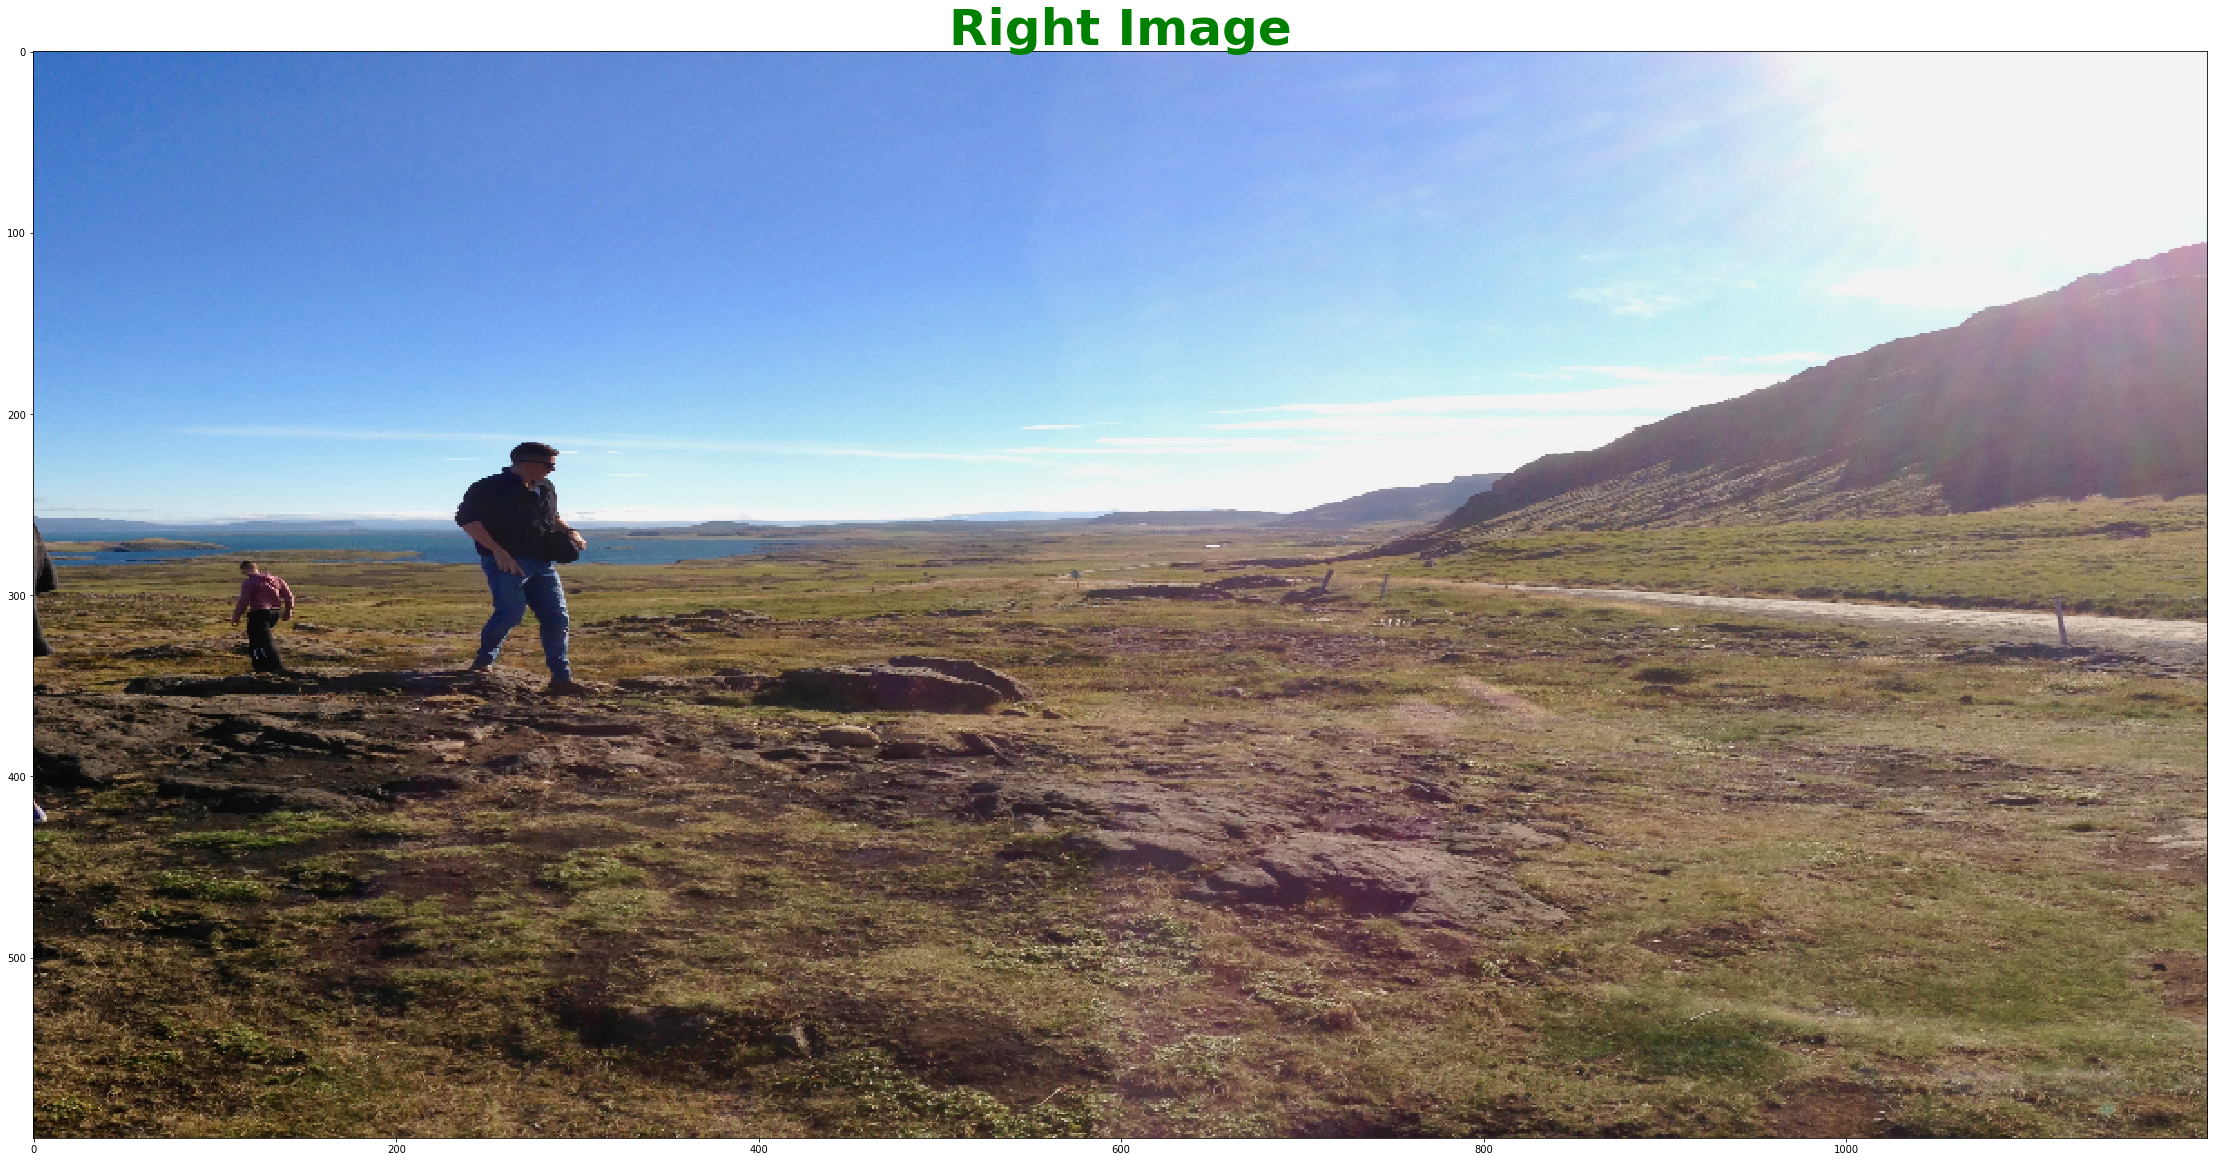

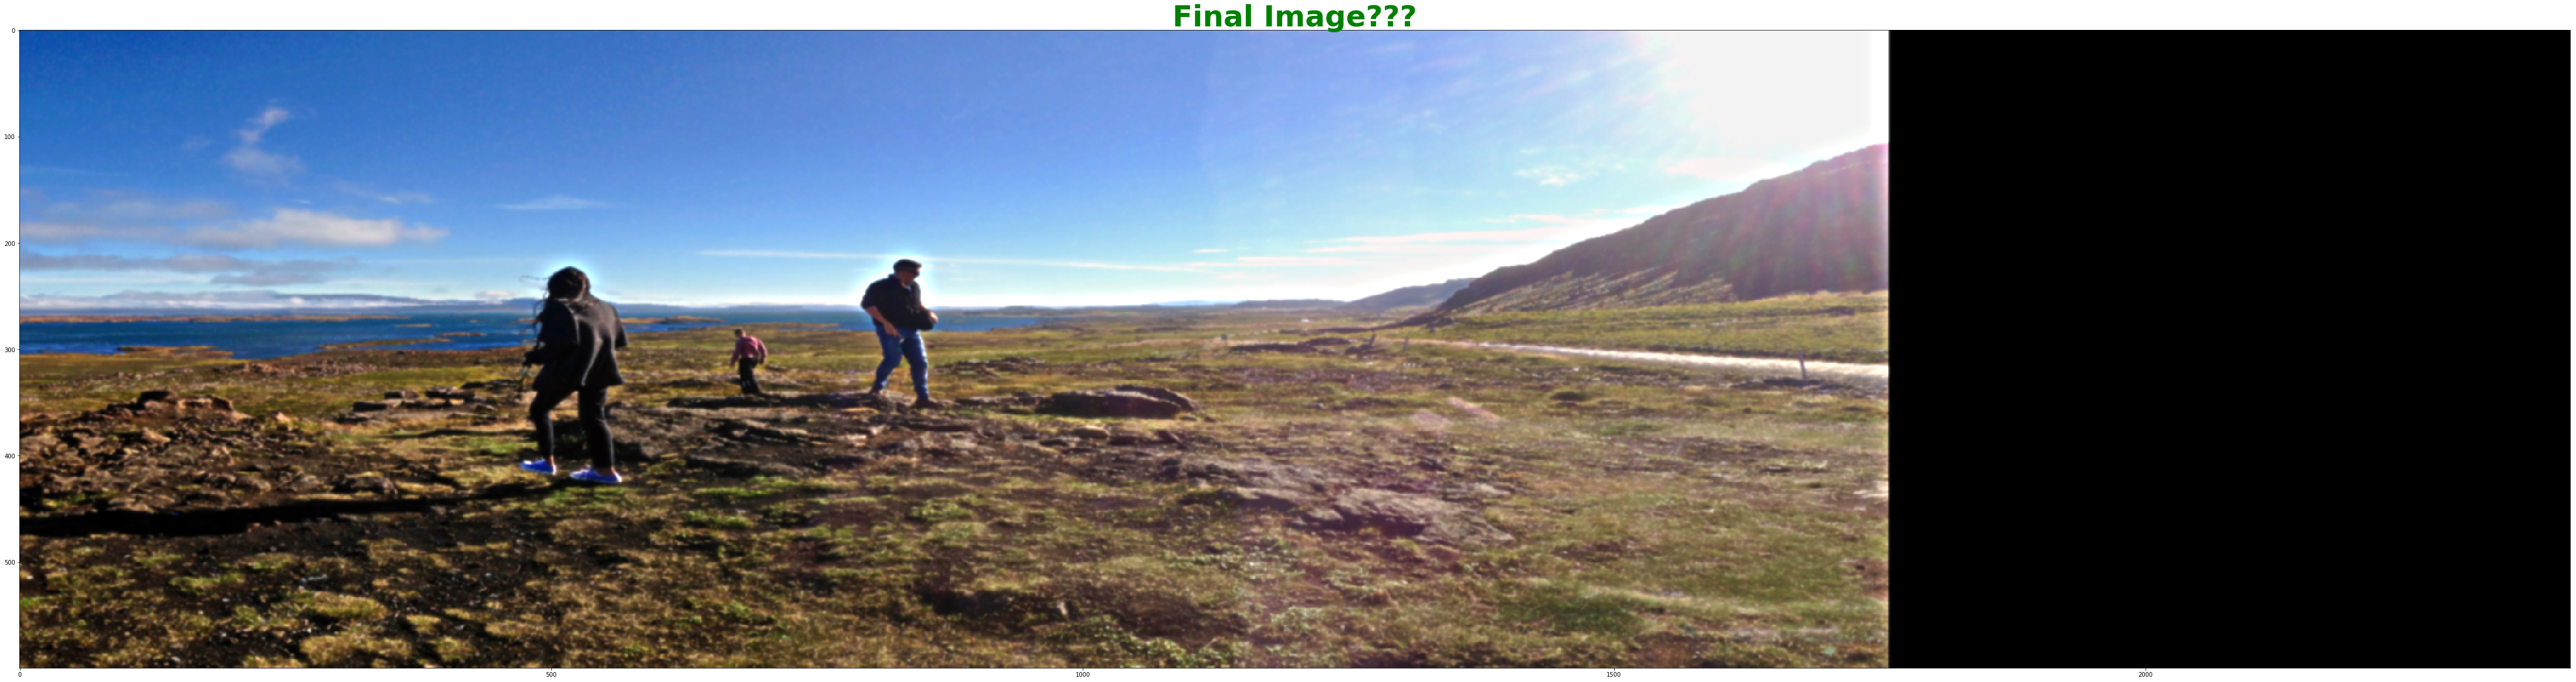

In [10]:
"""
    NOTES:
    CITATIONS:
        -MCgill OpenCV Tutorial Code for the Ransac and ouput limits functions
"""
'''
    LIBRARIES
'''
from tqdm import tnrange
from time import sleep
import cv2
from matplotlib import pyplot as plt
import os
import numpy as np
'''
    MAGIC VARIABLES
'''



class Panorama:
    DEBUG = False
    t = None
    FONT_SIZE = 50
    outputImages = []
    kp1 = []
    des1 = []
    kp2 = []
    des2 = []
    matches = []
    homographyMatrix = []
    finalShape = (0, 0)
    rightGaussianPyramid = []
    leftGaussianPyramid = []

    leftLaplacianPyramid = []
    rightLaplacianPyramid = []

    def resizeImage(self, image, dbug=DEBUG):
        if dbug:
            image = cv2.resize(image, (1200, 600))
        # image = cv2.resize(image, (120, 160))
        # image = cv2.resize(image, (1920, 2560))
        else:
#             image = cv2.resize(image, (2400, 1200))
            image = cv2.resize(image, (1200, 600))
        return image

    def displayImage(self, img):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)

    def displayImages(self, images):
        print("Displaying outs")
        for im in images:
            ima = im[0]
            ima = cv2.cvtColor(ima, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(80,20))
            plt.title(im[1], fontsize=self.FONT_SIZE, fontweight='bold', color="green")
            plt.imshow(ima)

    def convolutionFunction2(self, image, kernel):
        '''
        This function takes as input an image and then convolves it with the spec. kernel
        :param image: The original black and white image
        :param kernel: A 3x3 kernel
        :return: The filtered image
        '''
        image = np.array(image, dtype=np.float32)

        # Zero pad the image
        image = np.pad(image, 1, "constant")

        # FLIP THE KERNEL?? https://en.wikipedia.org/wiki/Kernel_(image_processing)
        kernel = np.fliplr(kernel)

        # Convert kernel to a 1x9 matrix
        kernel = np.reshape(kernel, (1, 9))

        # Then start convolving
        sz = image.shape
        newImg = np.zeros(sz, dtype=np.float32)
        # print ("Convoluding image with specified kernel" + str(kernel))
        for i in tnrange(range(1, sz[0] - 1), desc="Convolution function"):
            for j in range(1, sz[1] - 1):
                window = image[i - 1:i + 2, j - 1:j + 2]  # First get the points that make up our window
                # Then convolve the kernel with these points
                m1 = np.reshape(window, (1, 9))
                newImg[i][j] = np.inner(kernel, m1)

        return newImg

    def gaussian_filter2(self, im):
        """
        We need to apply a Gaussian filter to smooth out the original image somewhat
        The old implementation was too slow
        :param ix2: Padded X_squared derivative image
        :param iy2:'' y_ysqured'' ...
        :param ixy:
        :return:
        """
        kernel = [
            [1, 2, 1],
            [2, 4, 2],
            [1, 2, 1]
        ]
        kernel = np.array(kernel, dtype=np.float32)
        kernel / 16

        im = self.convolutionFunction2(im, kernel)

        return im

    def getSiftMatches(self):
        sift_1, sift_2 = cv2.xfeatures2d.SIFT_create(), cv2.xfeatures2d.SIFT_create()
        print("Finding the right image keypoints")
        self.kp1, self.des1 = sift_1.detectAndCompute(self.imL, None)
        print("Finding the left image keypoints")
        self.kp2, self.des2 = sift_2.detectAndCompute(self.imR, None)

        # Then find the matches between the images
        print("Finding matches between images")
        bf = cv2.BFMatcher()
        self.matches = bf.match(self.des1, self.des2)

        # then find the top  matches for a nice drawing
        bMatches = sorted(self.matches, key=lambda x: x.distance, reverse=False)[:20]
        newImBest = cv2.drawMatches(self.imL, self.kp1, self.imR, self.kp2, bMatches, None, flags=2)
        newImAll = cv2.drawMatches(self.imL, self.kp1, self.imR, self.kp2, self.matches, None, flags=2)
        if self.DEBUG:
            self.outputImages.append((newImBest, "20 best matches"))
            self.outputImages.append((newImAll, "All the best matches"))

    def getPanoImages(self, pathL, pathR):

        self.imL = self.resizeImage(cv2.imread(pathL))
        self.imR = self.resizeImage(cv2.imread(pathR))

        self.outputImages.append((self.imL, "Left Image"))
        self.outputImages.append((self.imR, "Right Image"))

    def getHomographyMatrix(self):
        # First we need to get the coordinates of points that match in the 2 images
        srcCoords = np.zeros((len(self.matches), 2))
        dstCoords = np.zeros((len(self.matches), 2))

        for idx in range(len(self.matches)):
            srcIdx, dstIdx = self.matches[idx].queryIdx, self.matches[idx].trainIdx
            srcCoords[idx] = self.kp1[srcIdx].pt
            dstCoords[idx] = self.kp2[dstIdx].pt

        # Finally compute the homography
        self.homographyMatrix, mask = cv2.findHomography(dstCoords, srcCoords, cv2.RANSAC, 5.0)

    def computePanoDetails(self):
        '''
        We need to know the shape of the new output image in order to solve our problem
        Use the sum of widths of 2 images and then the height of the second image
        :return:
        '''
        shp1 = self.imL.shape
        shp2 = self.imR.shape
        self.finalShape = (shp1[1] + shp2[1], shp1[0])

    def createLaplacianPyramids(self, levels=4):
        '''
            This will create the Laplacian pyramids for image blending
            http://www.cs.toronto.edu/~mangas/teaching/320/slides/CSC320L10.pdf
            ^^^Followed this tutorial
        '''
        # First compute the image pyramid for each image
        left, right = self.imL, self.rightWarped
        leftPyramid = []
        rightPyramid = []
        leftGaussianPyramid = []
        rightGaussianPyramid = []


        for i in range(levels):
            # First get the left and right gaussian pyramid

            left_gaussian = cv2.GaussianBlur(left, (5, 5), 0)
            right_gaussian = cv2.GaussianBlur(right, (5, 5), 0)

            # Log each image to the output
            # if self.DEBUG:
                # self.outputImages.append((left, "Left Pyramid Level: " + str(i)))
                # self.outputImages.append((right, "Right Pyramid Level: " + str(i)))
                # self.outputImages.append((left_gaussian, "Left BLURRED/GAUS Pyramid Level: " + str(i)))
                # self.outputImages.append((right_gaussian, "Right BLURRED/GAUS Pyramid Level: " + str(i)))

            leftPyramid.append(left)
            rightPyramid.append(right)
            leftGaussianPyramid.append(left_gaussian)
            rightGaussianPyramid.append(right_gaussian)

            # Then resize them for the next pyramid level
            left = cv2.resize(left, (0, 0), fx=0.5, fy=0.5)
            right = cv2.resize(right, (0, 0), fx=0.5, fy=0.5)

        self.leftGaussianPyramid = leftGaussianPyramid
        self.rightGaussianPyramid = rightGaussianPyramid

        # Then find the Gaussian pyramid on the weight image
        for i in range(levels - 1):
            # First get the left and right gaussian pyramids
            l_gauss = leftGaussianPyramid[i]
            l_gaussNxtLvl = cv2.resize(leftGaussianPyramid[i + 1], (0, 0), fx=2, fy=2)
            r_gauss = rightGaussianPyramid[i]
            r_gaussNxtLvl = cv2.resize(rightGaussianPyramid[i + 1], (0, 0), fx=2, fy=2)

            # Then get the laplacian pyramid by subtracting the two images from one another
            lapLeft = cv2.subtract(l_gauss, l_gaussNxtLvl)
            lapRight = cv2.subtract(r_gauss, r_gaussNxtLvl)

            self.leftLaplacianPyramid.append(lapLeft)
            self.rightLaplacianPyramid.append(lapRight)

        print "done"
    def combineLaplacianPyramids(self, levels=4):
        '''
        Blend Laplacians from each image using Gaussian blurred weights
        # Now add left and right halves of images in each level

        The following code snippet (although modified) has been taken from:
        http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_pyramids/py_pyramids.html
        '''
        combinedLaplacian = []
        combinedGaussian = []
        for i in range(levels-1)[::-1]:
            #Stich the left and right laplacians together, AFTER getting them back
            left_lap = self.leftLaplacianPyramid[i]
            right_lap = self.rightLaplacianPyramid[i]
            right_lap[0:left_lap.shape[0], 0:left_lap.shape[1]] = left_lap #The combining part
            combinedLaplacian.append(right_lap)

            #stich the left and right gaussians together
            left_gaus = self.leftGaussianPyramid[i]
            right_gaus = self.rightGaussianPyramid[i]
            right_gaus[0:left_gaus.shape[0], 0:left_gaus.shape[1]] = left_gaus  # The combining part
            combinedGaussian.append(right_gaus)

        # Then add top level laplacian to level below it to get final image...
        current_LAP = combinedLaplacian[0]
        for i in range(1,levels-1):
            belowLAP = combinedLaplacian[i]
            topLAP = cv2.resize(current_LAP,(0,0),fx=2,fy=2)
            current_LAP = cv2.add(belowLAP,topLAP)

        panorama = cv2.add(current_LAP,combinedGaussian[-1])
        panorama2 = cv2.add(current_LAP,)
        self.outputImages.append((panorama, "Final Image???"))
        self.outputImages.append(())

    def warpImages(self):
        # First apply the warping function on the right image
        # apply a perspective transform to stitch the images together
        # using the cached homography matrix
        # imageA = self.imR
        # imageB = self.imL
        # result = cv2.warpPerspective(imageA, self.homographyMatrix,
        #                              (imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
        # result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB
        # self.outputImages.append((result,"STITCHED IMAGES"))


        self.rightWarped = cv2.warpPerspective(self.imR, self.homographyMatrix, self.finalShape)
        
    def finalStitch(self):
        # then place the right image on the left image
        self.panorama = self.panoUnblended  # todo change this
        self.panorama[0:self.imR.shape[0], 0:self.imR.shape[1]] = self.imL

        # Then display our panorama!!
        self.outputImages.append((self.panorama, "Final panorama"))

    def main(self):
        self.t = tnrange(10, desc='Bar desc', leave=True)
        # t = tnrange(6, desc='Bar desc', leave=True)

        # First read the images as input
        self.t.set_description("Reading the landscape images")
        self.t.update(1)
        self.getPanoImages("./images/landscapeL.jpg", "./images/landscapeR.jpg")

        # Then compute the sift descriptors and matches
        self.t.set_description("Get sift features and calculate matches")
        self.t.update(1)
        self.getSiftMatches()

        # Then get the homography matrix
        self.t.set_description("Get homography matrix")
        self.t.update(1)
        self.getHomographyMatrix()

        # Then get the final image details
        self.t.set_description("Get final image details")
        self.t.update(1)
        self.computePanoDetails()

        # Then do a warping transformation on the images using this matrix
        self.t.set_description("Warping the right image onto the left image")
        self.t.update(1)
        self.warpImages()

        self.t.set_description("Applying the Laplacian blending of the image")
        self.t.update(1)
        self.createLaplacianPyramids()

        self.t.set_description("Create the Gausian weight pyramid")
        self.t.update(1)
        self.combineLaplacianPyramids()

        self.t.set_description("Applying the ")

        # Finally display all of the output images
        self.t.set_description("Displaying the output images")
        self.t.update(1)
        self.displayImages(self.outputImages)


%pylab inline
plt.rcParams['figure.figsize'] = (120, 60)
%matplotlib inline
p = Panorama()
p.main()


# TQDM EXAMPLE

In [6]:
from tqdm import tnrange, tqdm_notebook
import time
# for i in tnrange(2, desc='1st loop'):
#     for j in tqdm_notebook(range(100), desc='2nd loop'):
#         time.sleep(0.01)
                
t = tnrange(10, desc='Bar desc')

t.set_description("Reading the landscape images")
t.refresh()
for i in range(10):
    
    t.update(1)
    time.sleep(1)


0/|/Reading the landscape images:   0%|| 0/10 [00:00<?, ?it/s]